In [1]:
import os
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb

from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.utils import util
from mejiro.instruments.hwo import HWO

# read configuration file
with open('/grad/bwedig/mejiro/projects/pipeline/hwo.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
if config['dev']:
    config['pipeline_label'] += '_dev'

In [3]:
lenses = util.unpickle_all(os.path.join(config['data_dir'], config['pipeline_label'], '02'))
print(f'Found {len(lenses)} strong lens(es)')

# name_snr_pairs = util.unpickle('/data/bwedig/mejiro/hwo/snr/name_snr_pairs.pkl')
# snr_dict = dict(name_snr_pairs)

# # Sort lenses by SNR, matching on exposure.synthetic_image.strong_lens.name
# sorted_lenses = sorted(
#     lenses,
#     key=lambda lens: snr_dict.get(lens.name, -np.inf),
#     reverse=True
# )

# print(snr_dict)

Found 370 strong lens(es)


In [4]:
sample = lenses[22]
pprint(sample.physical_params['magnitudes'])

{'lens': {'B': 23.689008861192406,
          'F062': 22.84367683828299,
          'F087': 21.293276424326002,
          'F106': 20.731977454677306,
          'F129': 20.347497154612988,
          'F146': 20.19633490076643,
          'F158': 20.010062367716188,
          'F184': 19.74963335909664,
          'F213': 19.56224032943399,
          'F438W': 23.70160604752993,
          'F475W': 23.672217378924444,
          'F606W': 23.100801383442658,
          'F814W': 21.697345315140723,
          'FUV': 23.989817980909272,
          'H': 19.992538219930722,
          'I': 21.430491422239264,
          'J': 20.38277696403709,
          'K': 19.54014999815368,
          'NUV': 23.85451314328278,
          'R': 21.932230877935908,
          'U': 23.857382939302184,
          'V': 23.01977696335009,
          'g': 23.66679250063556,
          'i': 22.06417394144882,
          'r': 22.92071051667657,
          'u': 23.77846566712298,
          'y': 20.941841508737866,
          'z': 21.314806

Scene size: 5.001921551492087 arcsec, 291 pixels at pixel scale 0.017188733853924696 arcsec/pix


/grad/bwedig/mejiro/mejiro/synthetic_image.py:252: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(self.image), origin='lower')


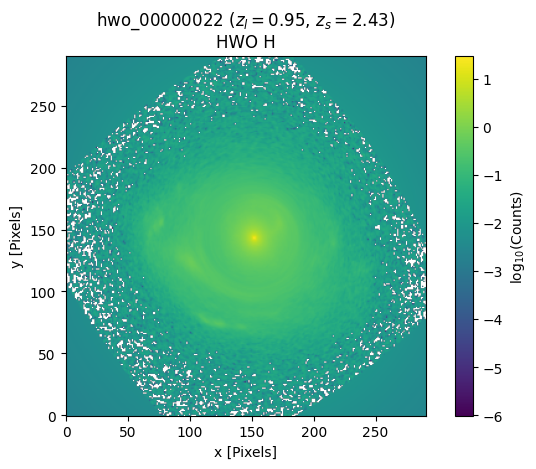

Exposure calculation time with galsim engine: 0.076 s


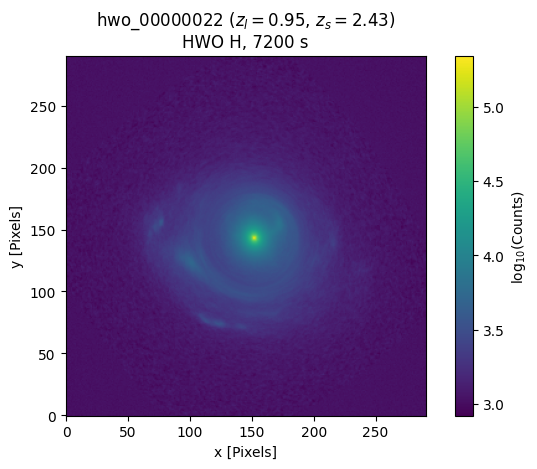

In [5]:
synthetic_image_hwo = SyntheticImage(strong_lens=sample,
                                     instrument=HWO(),
                                     band='H',
                                     verbose=True)
synthetic_image_hwo.plot()

exposure_hwo = Exposure(synthetic_image=synthetic_image_hwo,
                        exposure_time=7200,
                        # engine='lenstronomy',
                        verbose=True)
exposure_hwo.plot()

In [7]:
pprint(sample.kwargs_lens_light)

[{'R_sersic': 0.5767061482381075,
  'amp': 599.311162696393,
  'center_x': 0.10857322614192236,
  'center_y': -0.03238364241650622,
  'e1': -0.04503112514139083,
  'e2': -0.029509647366715994,
  'n_sersic': 4.0}]


In [ ]:
# from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
# from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid
# from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.SimulationAPI.ObservationConfig.JWST import JWST

In [ ]:
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)
lsst = [LSST_g, LSST_r, LSST_i]



In [ ]:
kwargs_model = sample.kwargs_model
kwargs_lens = sample.kwargs_lens

In [ ]:
def simulate_rgb(ConfigList, size, kwargs_numerics):
    band_b, band_g, band_r = ConfigList
    kwargs_b_band = band_b.kwargs_single_band()
    kwargs_g_band = band_g.kwargs_single_band()
    kwargs_r_band = band_r.kwargs_single_band()
    
    # set number of pixels from pixel scale
    pixel_scale = kwargs_g_band['pixel_scale']
    numpix = int(round(size / pixel_scale))

    sim_b = SimAPI(numpix=numpix, kwargs_single_band=kwargs_b_band, kwargs_model=kwargs_model)
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_b = sim_b.image_model_class(kwargs_numerics)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)


    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_b.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_g.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_r.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)


    image_b = imSim_b.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
    image_g = imSim_g.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

    # add noise
    image_b += sim_b.noise_for_model(model=image_b)
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)

    # and plot it

    img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    #scale_max=10000
    def _scale_max(image): 
        flat=image.flatten()
        flat.sort()
        scale_max = flat[int(len(flat)*0.95)]
        return scale_max
    img[:,:,0] = plot_util.sqrt(image_b, scale_min=0, scale_max=_scale_max(image_b))
    img[:,:,1] = plot_util.sqrt(image_g, scale_min=0, scale_max=_scale_max(image_g))
    img[:,:,2] = plot_util.sqrt(image_r, scale_min=0, scale_max=_scale_max(image_r))
    data_class = sim_b.data_class
    return img, data_class

In [ ]:
size = 6. # width of the image in units of arc seconds

img_des, coords_des = simulate_rgb(des, size=size, kwargs_numerics=kwargs_numerics)
img_lsst, coords_lss = simulate_rgb(lsst, size=size, kwargs_numerics=kwargs_numerics)
img_roman, coords_roman = simulate_rgb(roman, size=size, kwargs_numerics=kwargs_numerics)

NameError: name 'exposure_lsst' is not defined

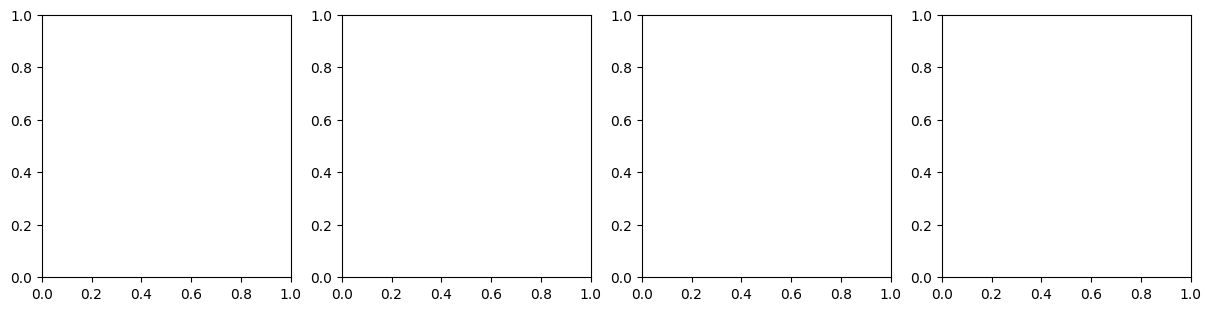

In [36]:
f, ax = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)
ax[0].imshow(exposure_lsst.exposure)
ax[0].set_title('LSST i (0.2"/pix)')
ax[1].imshow(exposure_hst.exposure)
ax[1].set_title('HST WFC3 UVIS F814W (0.04"/pix)')
ax[3].set_title('Roman F129 (0.1"/pix)')
ax[2].imshow(exposure_hwo.exposure)
ax[2].set_title('HWO I (0.005"/pix)')
ax[3].imshow(exposure_hwo.exposure)
for a in ax.flatten():
    a.axis('off')
plt.show()